# Resnet con class weight

Como vimos que en los aproach pasados obtuvimos un performance pobre utilizando undersampling, no solo en test sino en train, vemos que hay bias en esos modelos. Por lo cual en este aproach aumentamos la complejidad utilizando resnet y classweight.

In [ ]:
!wget https://storage.googleapis.com/diabetic-detection/data_downscaled.zip

--2020-11-15 22:41:34--  https://storage.googleapis.com/diabetic-detection/data_downscaled.zip
Resolving storage.googleapis.com (storage.googleapis.com)... 142.250.73.208, 142.250.73.240, 172.217.13.240, ...
Connecting to storage.googleapis.com (storage.googleapis.com)|142.250.73.208|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 990385145 (945M) [application/zip]
Saving to: ‘data_downscaled.zip’

data_downscaled.zip 100%[===================>] 944.50M   100MB/s    in 8.2s    

2020-11-15 22:41:42 (115 MB/s) - ‘data_downscaled.zip’ saved [990385145/990385145]



In [ ]:
!unzip -o -q data_downscaled
!mv .tmp dataset
!mv dataset/raw_dataset_extracted_downscaled data
!rm -rf dataset

In [ ]:
!ls -l data

total 4196
drwxr-xr-x 2 root root    4096 Nov  6 05:56 sample
-rw-r--r-- 1 root root  709972 Nov  6 05:56 sampleSubmission.csv
drwxr-xr-x 2 root root 1929216 Nov  6 04:51 test
drwxr-xr-x 2 root root 1183744 Nov  6 05:56 train
-rw-r--r-- 1 root root  465317 Nov  6 05:56 trainLabels.csv


## Carga y configuración del dataset

In [ ]:
import pandas as pd
import numpy as np
import os, sys, shutil
from sklearn.model_selection import train_test_split

In [ ]:
labels = pd.read_csv('data/trainLabels.csv') \
  .sort_values(by = 'image')

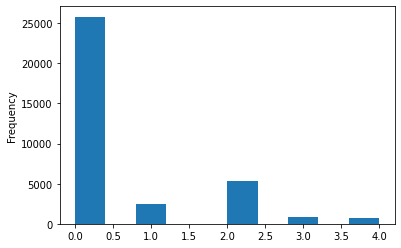

In [ ]:
labels.level.plot(kind = 'hist')

In [ ]:
train, test = train_test_split(labels, train_size = 0.8, stratify = labels.level, random_state = 42)

In [ ]:
train.shape[0], test.shape[0]

(28100, 7026)

In [ ]:
label_names = {
  0: 'No DR',
  1: 'Mild',
  2: 'Moderate',
  3: 'Severe',
  4: 'Proliferative DR'
}

In [ ]:
flow_dataset_dir = 'data/flow_dataset'
images_dataset_dir = 'data/train'

def create_directory_flow(df, subset_name):
  for _, row in df.iterrows():
    item = row.image
    level = row['level']
    label_name = label_names[level]
    ext = '.jpeg'
    orig_file = os.path.join(images_dataset_dir, item + ext)
    os.makedirs(os.path.join(flow_dataset_dir, subset_name, label_name), exist_ok=True)
    dest_file = os.path.join(flow_dataset_dir, subset_name, label_name, item + ext)
    shutil.copy(orig_file, dest_file)

In [ ]:
create_directory_flow(train, 'train')
create_directory_flow(test, 'validation')

In [ ]:
!ls -l data/flow_dataset
!ls -l data/flow_dataset/train
!ls -l data/flow_dataset/validation

total 8
drwxr-xr-x 7 root root 4096 Nov 15 22:42 train
drwxr-xr-x 7 root root 4096 Nov 15 22:42 validation
total 980
drwxr-xr-x 2 root root  69632 Nov 15 22:42  Mild
drwxr-xr-x 2 root root 135168 Nov 15 22:42  Moderate
drwxr-xr-x 2 root root 720896 Nov 15 22:42 'No DR'
drwxr-xr-x 2 root root  24576 Nov 15 22:42 'Proliferative DR'
drwxr-xr-x 2 root root  32768 Nov 15 22:42  Severe
total 256
drwxr-xr-x 2 root root  20480 Nov 15 22:42  Mild
drwxr-xr-x 2 root root  36864 Nov 15 22:42  Moderate
drwxr-xr-x 2 root root 180224 Nov 15 22:42 'No DR'
drwxr-xr-x 2 root root   4096 Nov 15 22:42 'Proliferative DR'
drwxr-xr-x 2 root root  12288 Nov 15 22:42  Severe


## Confección del modelo

In [ ]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.applications import ResNet50
from tensorflow.keras.layers import GlobalAveragePooling2D, Input, Dense, Dropout
from tensorflow.keras.models import Model
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint
from tensorflow.keras.metrics import AUC, FalseNegatives, TruePositives
from tensorflow.keras import optimizers

In [ ]:
image_size = (448, 448)
image_shape = (448, 448, 3)
batch_size = 128

In [ ]:
train_path = os.path.join('data', 'flow_dataset', 'train')
validation_path = os.path.join('data', 'flow_dataset', 'validation')

train_datagen = ImageDataGenerator(
    rescale=1./255,
    horizontal_flip=False,
    zoom_range = .1
)
test_datagen = ImageDataGenerator(rescale=1./255)

kwargs = {
  'target_size': image_size,
  'batch_size': batch_size,
  'class_mode': 'categorical',
  'classes': label_names.values()
}
train_generator = train_datagen.flow_from_directory(train_path, **kwargs)
validation_generator = test_datagen.flow_from_directory(validation_path, **kwargs)

Found 28100 images belonging to 5 classes.
Found 7026 images belonging to 5 classes.


In [ ]:
def create_resnet50_model(
    resnet_weights = None,
    optimizer = 'adam',
    metrics = [
      'accuracy',
      AUC(name = 'auc'),
      FalseNegatives(name = 'false_positives'),
      TruePositives(name = 'true_positives')]):
  inputs = Input(shape=image_shape)

  # First big block is ResNet50
  resnet_args = {
      'input_shape': image_shape,
      'include_top': False,
      'weights': resnet_weights
  }

  conv_resnet50 = ResNet50(**resnet_args)
  if resnet_weights is not None: 
    conv_resnet50.trainable = False

  outputs = conv_resnet50(inputs)
  outputs = GlobalAveragePooling2D()(outputs)
  outputs = Dense(128, activation='relu')(outputs)
  outputs = Dropout(0.3)(outputs)
  outputs = Dense(64, activation='relu')(outputs)
  outputs = Dense(5, activation = 'softmax')(outputs)

  model = Model(inputs, outputs)
  model.compile(optimizer=optimizer, loss='categorical_crossentropy', metrics=metrics)
  return model

In [ ]:
class_weight = (1 / train.level.value_counts(normalize = True)).to_dict()

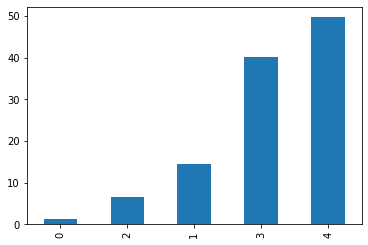

In [ ]:
(1 / train.level.value_counts(normalize = True)).plot(kind = 'bar')

In [ ]:
resnet50_model = create_resnet50_model(resnet_weights = 'imagenet', optimizer=optimizers.RMSprop(lr=1e-3))

94773248/94765736 [==============================] - 0s 0us/step


In [ ]:
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint

monitor_loss = EarlyStopping(monitor='val_loss', min_delta=0.001, patience=4,
                             restore_best_weights=True, verbose=1)
!mkdir -p resnet50_checkpoints

checkpoints_path = 'resnet50_checkpoints/weights.{epoch:02d}-{val_loss:.2f}.h5'
checkpoint = ModelCheckpoint(checkpoints_path, monitor='val_loss', verbose=0,
                             save_best_only=True, save_weights_only=False, mode='auto')

callbacks = [monitor_loss, checkpoint]

In [ ]:
# Entrenamos nuestro modelo
history = resnet50_model.fit(train_generator,
  steps_per_epoch=train_generator.n//train_generator.batch_size,
  epochs=30,
  validation_data=validation_generator,
  validation_steps=validation_generator.n//validation_generator.batch_size,
  class_weight=class_weight,
  callbacks=callbacks)

Epoch 1/30
219/219 [==============================] - 1274s 6s/step - loss: 8.1854 - accuracy: 0.3053 - auc: 0.5584 - false_positives: 27874.0000 - true_positives: 98.0000 - val_loss: 1.6010 - val_accuracy: 0.7358 - val_auc: 0.7256 - val_false_positives: 6912.0000 - val_true_positives: 0.0000e+00
Epoch 2/30
219/219 [==============================] - 1219s 6s/step - loss: 8.0459 - accuracy: 0.5028 - auc: 0.6659 - false_positives: 27972.0000 - true_positives: 0.0000e+00 - val_loss: 1.6054 - val_accuracy: 0.1510 - val_auc: 0.6909 - val_false_positives: 6912.0000 - val_true_positives: 0.0000e+00
Epoch 3/30
219/219 [==============================] - 1220s 6s/step - loss: 8.0564 - accuracy: 0.2085 - auc: 0.5384 - false_positives: 27972.0000 - true_positives: 0.0000e+00 - val_loss: 1.6079 - val_accuracy: 0.1506 - val_auc: 0.4691 - val_false_positives: 6912.0000 - val_true_positives: 0.0000e+00
Epoch 4/30
219/219 [==============================] - 1220s 6s/step - loss: 8.0470 - accuracy: 0.376

In [ ]:
import matplotlib.pyplot as plt

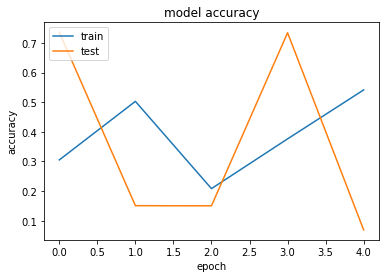

In [ ]:
# summarize history for accuracy
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

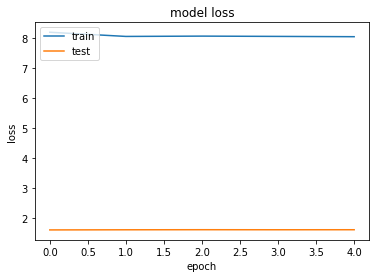

In [ ]:
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

In [ ]:
y_preds = resnet50_model.predict_generator(
    validation_generator,
    len(validation_generator)
)

y_preds_labels = np.argmax(y_preds, axis=1)

Instructions for updating:
Please use Model.predict, which supports generators.


In [ ]:
from sklearn.metrics import classification_report, confusion_matrix, balanced_accuracy_score
import seaborn as sns

In [ ]:
print(confusion_matrix(validation_generator.classes, y_preds_labels))

[[5162    0    0    0    0]
 [ 489    0    0    0    0]
 [1058    0    0    0    0]
 [ 175    0    0    0    0]
 [ 142    0    0    0    0]]


In [ ]:
print(classification_report(validation_generator.classes, y_preds_labels))

              precision    recall  f1-score   support

           0       0.73      1.00      0.85      5162
           1       0.00      0.00      0.00       489
           2       0.00      0.00      0.00      1058
           3       0.00      0.00      0.00       175
           4       0.00      0.00      0.00       142

    accuracy                           0.73      7026
   macro avg       0.15      0.20      0.17      7026
weighted avg       0.54      0.73      0.62      7026



/usr/local/lib/python3.6/dist-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


In [ ]:
balanced_accuracy_score(validation_generator.classes, y_preds_labels)

0.2

Vemos que el modelo predice siempre la clase 2 a todas las imagenes